<a href="https://colab.research.google.com/github/sahal-mulki/learning-pytorch/blob/main/Part%206%20-%20Attribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision captum matplotlib==3.3.4 Flask-Compress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_

In [1]:
import torch, captum, os, sys, json
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
model = models.efficientnet_b5(models.EfficientNet_B5_Weights.IMAGENET1K_V1).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


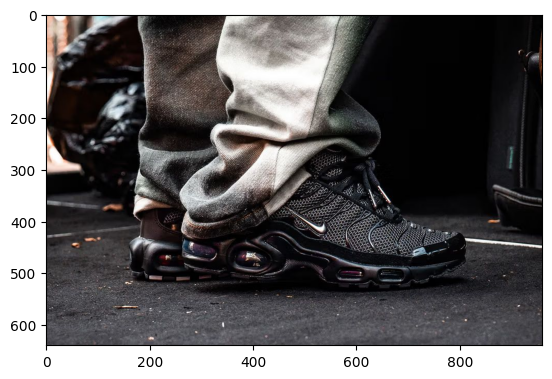

In [3]:
test_img = Image.open('/content/454742756_1273812686961742_6006887499193582979_n.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [ ]:
pip install graphviz torchview

In [4]:
!mkdir /content/img && cd /content/img && wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

--2024-08-25 00:02:17--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.007s  

2024-08-25 00:02:17 (4.57 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [4]:
# model expects 224x224 3-color image
transform = transforms.Compose([
    transforms.Resize(456),
    transforms.CenterCrop(456),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])  # Explicitly define the necessary transforms

transformed_img = transform(test_img)
input_img = transformed_img.unsqueeze(0) # Use the transformed image here and add the batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [5]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: running_shoe ( 0.6342272758483887 )


In [6]:
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

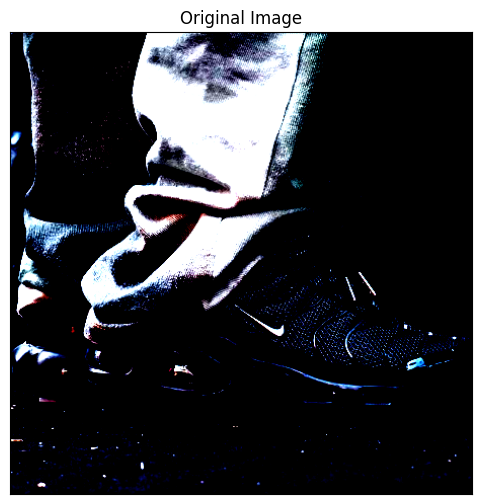

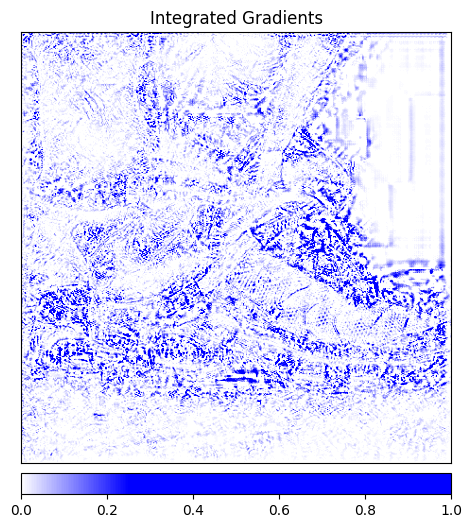

In [7]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200, internal_batch_size=6)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [25]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38657 sha256=5dfa5a9d4812cbec71e35baf248afdf29d7d97a19c603bad95924339cc4d6881
  Stored in directory: /root/.cache/pip/wheels/2e/ce/70/fe64f851895eae830b3c63ec7fc464cfa7c81aeb7ad4f68063
Successfully built grad-cam


In [9]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.features[-2]]
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(770)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_img, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  img_normalized = np.transpose((transformed_img.squeeze().cpu().detach().numpy() / 255.0), (1,2,0)).astype(np.float32)
  visualization = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

array([[[  1,   1, 128],
        [  0,   1, 128],
        [  0,   0, 127],
        ...,
        [254, 172, 250],
        [254, 172, 250],
        [254, 172, 250]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [254, 172, 250],
        [254, 172, 250],
        [254, 172, 250]],

       [[  0,   0, 127],
        [  0,   0, 126],
        [  0,   0, 126],
        ...,
        [254, 172, 250],
        [254, 172, 250],
        [254, 172, 250]],

       ...,

       [[  0,   0, 205],
        [  0,   0, 205],
        [  0,   0, 205],
        ...,
        [  0, 224, 252],
        [  0, 225, 252],
        [  0, 225, 252]],

       [[  0,   0, 205],
        [  0,   0, 205],
        [  0,   0, 205],
        ...,
        [  0, 224, 252],
        [  0, 225, 252],
        [  0, 225, 252]],

       [[  0,   0, 205],
        [  0,   0, 205],
        [  0,   0, 205],
        ...,
        [  0, 224, 252],
        [  0, 225, 252],
        [  0, 225, 252]]], dtype=uint8)
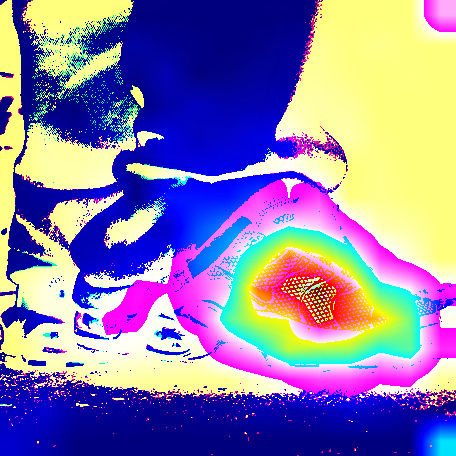

In [10]:
visualization

In [13]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.features[-2]]
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(770)]

# Construct the CAM object once, and then re-use it on many images.
with EigenGradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_img, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  img_normalized = np.transpose((transformed_img.squeeze().cpu().detach().numpy() / 255.0), (1,2,0)).astype(np.float32)
  visualization = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

array([[[  1,   1, 128],
        [  0,   1, 128],
        [  0,   0, 127],
        ...,
        [254, 255, 125],
        [254, 255, 125],
        [254, 255, 125]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [254, 255, 125],
        [254, 255, 125],
        [254, 255, 125]],

       [[  0,   0, 127],
        [  0,   0, 126],
        [  0,   0, 126],
        ...,
        [254, 255, 125],
        [254, 255, 125],
        [254, 255, 125]],

       ...,

       [[  0,   0, 126],
        [  0,   0, 126],
        [  0,   0, 126],
        ...,
        [  0,   0, 126],
        [  0,   0, 126],
        [  0,   0, 126]],

       [[  0,   0, 126],
        [  0,   0, 126],
        [  0,   0, 126],
        ...,
        [  0,   0, 126],
        [  0,   0, 126],
        [  0,   0, 126]],

       [[  0,   0, 126],
        [  0,   0, 126],
        [  0,   0, 126],
        ...,
        [  0,   0, 126],
        [  0,   0, 126],
        [  0,   0, 126]]], dtype=uint8)
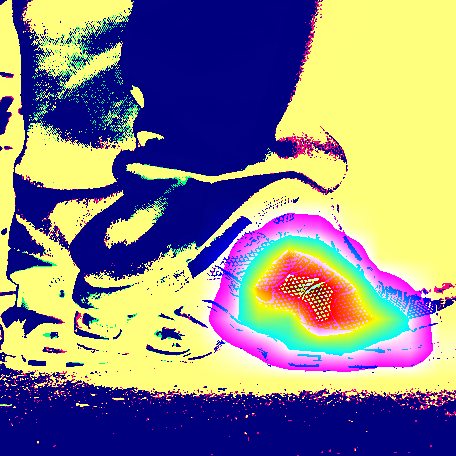

In [14]:
visualization

In [35]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.features[8]]
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(770)]

# Construct the CAM object once, and then re-use it on many images.
with EigenGradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_img, targets=targets, eigen_smooth=True, aug_smooth=True)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  img_normalized = np.transpose((transformed_img.squeeze().cpu().detach().numpy() / 255.0), (1,2,0)).astype(np.float32)
  visualization = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

array([[[  1, 100, 254],
        [  0, 100, 253],
        [  0,  99, 253],
        ...,
        [254, 255, 239],
        [254, 255, 239],
        [254, 255, 239]],

       [[  0,  99, 253],
        [  0,  99, 253],
        [  0,  99, 252],
        ...,
        [254, 255, 239],
        [254, 255, 239],
        [254, 255, 239]],

       [[  0,  99, 253],
        [  0,  98, 252],
        [  0,  98, 252],
        ...,
        [254, 255, 239],
        [254, 255, 239],
        [254, 255, 239]],

       ...,

       [[  0, 221, 252],
        [  0, 221, 252],
        [  0, 221, 252],
        ...,
        [  0,   7, 252],
        [  0,   7, 252],
        [  0,   7, 252]],

       [[  0, 221, 252],
        [  0, 221, 252],
        [  0, 221, 252],
        ...,
        [  0,   7, 252],
        [  0,   7, 252],
        [  0,   7, 252]],

       [[  0, 221, 252],
        [  0, 221, 252],
        [  0, 221, 252],
        ...,
        [  0,   7, 252],
        [  0,   7, 252],
        [  0,   7, 252]]], dtype=uint8)
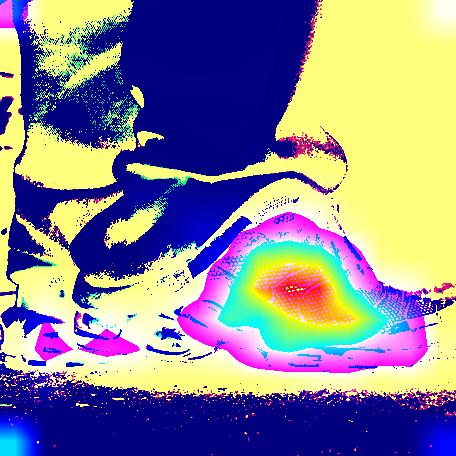

In [36]:
visualization